# Neural Network

## Table of content

- [Experiment on how imbalance affect the performance](#experiment-on-how-imbalance-affect-the-performance)
    - [Without handling imbalance](#Without-handling-imbalance)
    - [Using class weights](#Using-class-weights)
    - [Using oversampling ](#Using-oversampling )
    - [Results of the experiment](#Results-of-the-experiment)
- [Find the best model](#Find-the-best-model)

In [3]:
from Functions import get_result, get_best_threshold, plot_roc_curve, save_metrics_to_json
from keras import Sequential, models, utils, backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, BatchNormalization
from keras.losses import BinaryCrossentropy
from keras.metrics import (AUC, BinaryAccuracy, 
                           Precision, Recall, 
                           Metric, F1Score, 
                           TruePositives, FalsePositives, 
                           TrueNegatives, FalseNegatives)
from keras.optimizers import Adam
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
import datetime
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

Load the datasets for training (remember they are scaled)

In [4]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

In [6]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

We will start by creating a function to produce some plots of the models performance and loss on the training and validation set. These will help us check for overfitting.

In [7]:
def plot_training_metrics(history):
    metrics = [
        'loss', 
        'recall', 
        'precision', 
        #'F1'
        'prc'
    ]
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
BATCH_SIZE = 2048

Now, lets do an experiment of how our neural network would do, when we do not handle the imbalance in our dataset. Afterwards we'll try two different techniques to handle the imbalance.

## Experiment on how imbalance affect the performance
We'll create a function to create a simple model, which we can use for this experiment.

In [9]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(),
        loss=BinaryCrossentropy(from_logits=False),
        metrics=METRICS
    )

    return model

### Without handling imbalance

In [10]:
model = get_simple_model()

In [12]:
history_unhandled = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
134/134 [==============================] - 2s 17ms/step - loss: 0.0113 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 272559.0000 - fn: 385.0000 - accuracy: 0.9986 - precision: 0.0000e+00 - recall: 0.0000e+00 - prc: 0.0016 - val_loss: 0.0108 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 34070.0000 - val_fn: 48.0000 - val_accuracy: 0.9986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_prc: 0.0014
Epoch 2/20
134/134 [==============================] - 2s 14ms/step - loss: 0.0111 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 272559.0000 - fn: 385.0000 - accuracy: 0.9986 - precision: 0.0000e+00 - recall: 0.0000e+00 - prc: 0.0015 - val_loss: 0.0108 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 34070.0000 - val_fn: 48.0000 - val_accuracy: 0.9986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_prc: 0.0014
Epoch 3/20
134/134 [==============================] - 2s 14ms/step - loss: 0.0109 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 272559.0000 - fn: 385.0000 - accurac

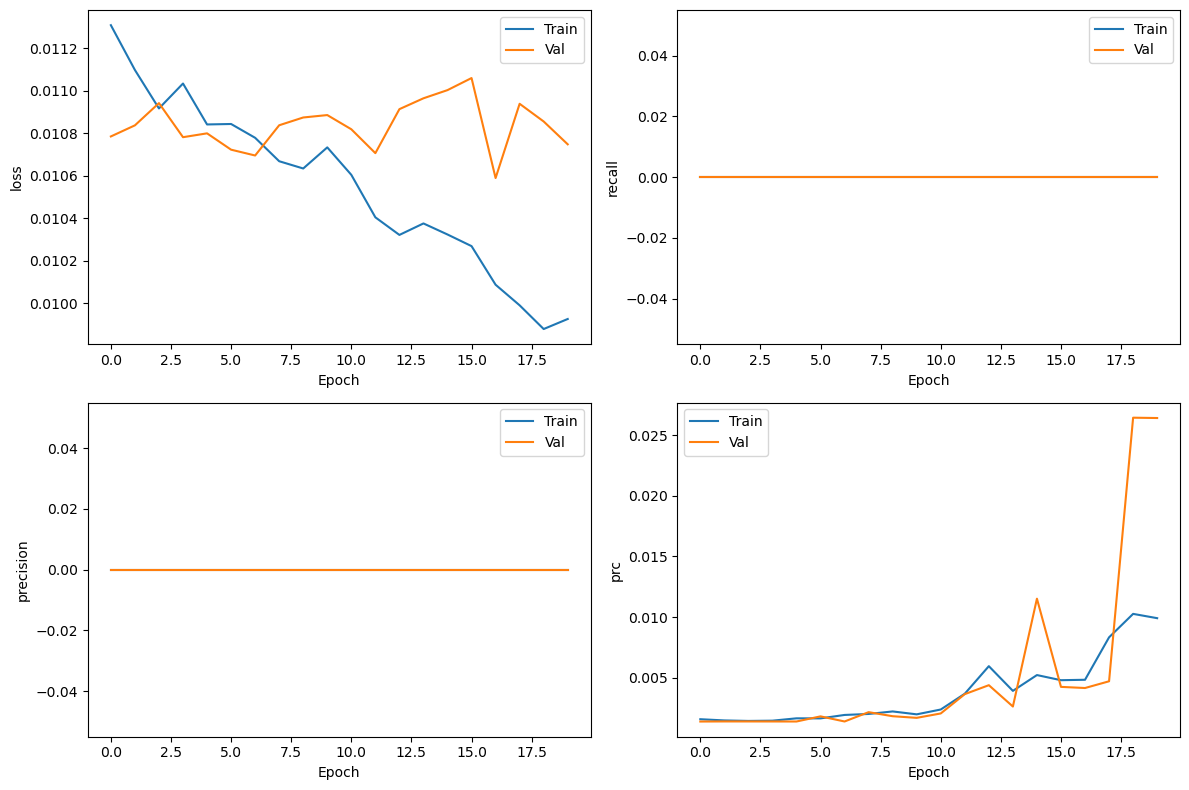

In [13]:
plot_training_metrics(history_unhandled)

In [14]:
val_predictions = model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


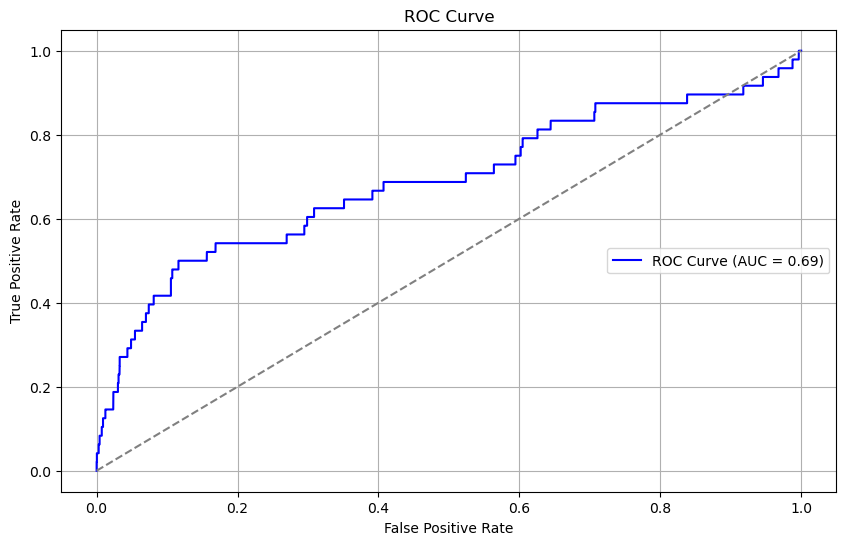

0.6884490265140397

In [15]:
plot_roc_curve(Y_val, val_predictions)

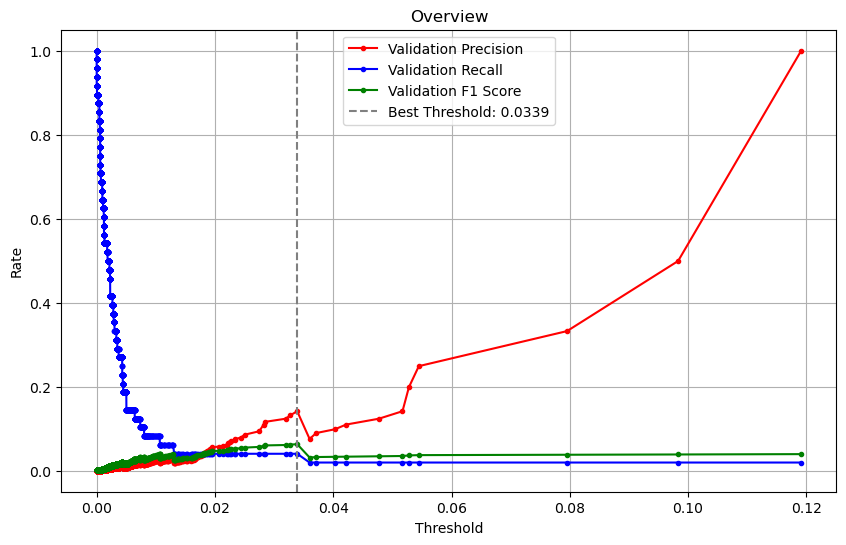

In [16]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [17]:
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


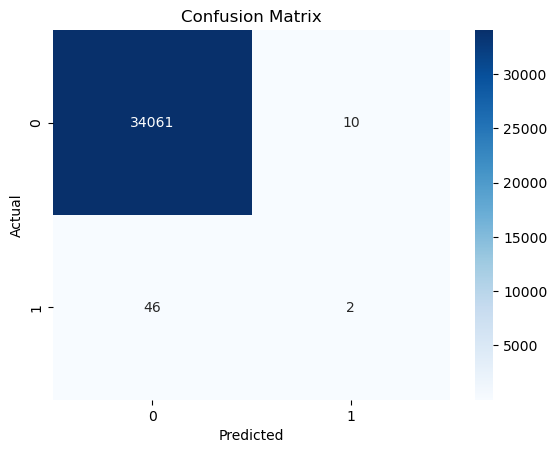

Recall       = 0.04
Precision    = 0.17
F1           = 0.07


In [18]:
_ = get_result(Y_test, test_predictions, best_threshold)

### Using class weights

In [19]:
# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.5007062691013688, 1: 354.4727272727273}

In [20]:
model = get_simple_model()

history_class_weights = model.fit(
    X_train,
    Y_train,
    class_weight=class_weights_dict,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
134/134 [==============================] - 4s 16ms/step - loss: 0.8001 - tp: 204.0000 - fp: 146322.0000 - tn: 160307.0000 - fn: 229.0000 - accuracy: 0.5227 - precision: 0.0014 - recall: 0.4711 - prc: 0.0015 - val_loss: 0.6596 - val_tp: 17.0000 - val_fp: 10117.0000 - val_tn: 23953.0000 - val_fn: 31.0000 - val_accuracy: 0.7026 - val_precision: 0.0017 - val_recall: 0.3542 - val_prc: 0.0015
Epoch 2/20
134/134 [==============================] - 2s 14ms/step - loss: 0.7483 - tp: 206.0000 - fp: 135284.0000 - tn: 137275.0000 - fn: 179.0000 - accuracy: 0.5037 - precision: 0.0015 - recall: 0.5351 - prc: 0.0017 - val_loss: 0.6008 - val_tp: 11.0000 - val_fp: 6899.0000 - val_tn: 27171.0000 - val_fn: 37.0000 - val_accuracy: 0.7967 - val_precision: 0.0016 - val_recall: 0.2292 - val_prc: 0.0017
Epoch 3/20
134/134 [==============================] - 2s 14ms/step - loss: 0.6973 - tp: 218.0000 - fp: 126640.0000 - tn: 145919.0000 - fn: 167.0000 - accuracy: 0.5354 - precision: 0.0017 - recall: 0.

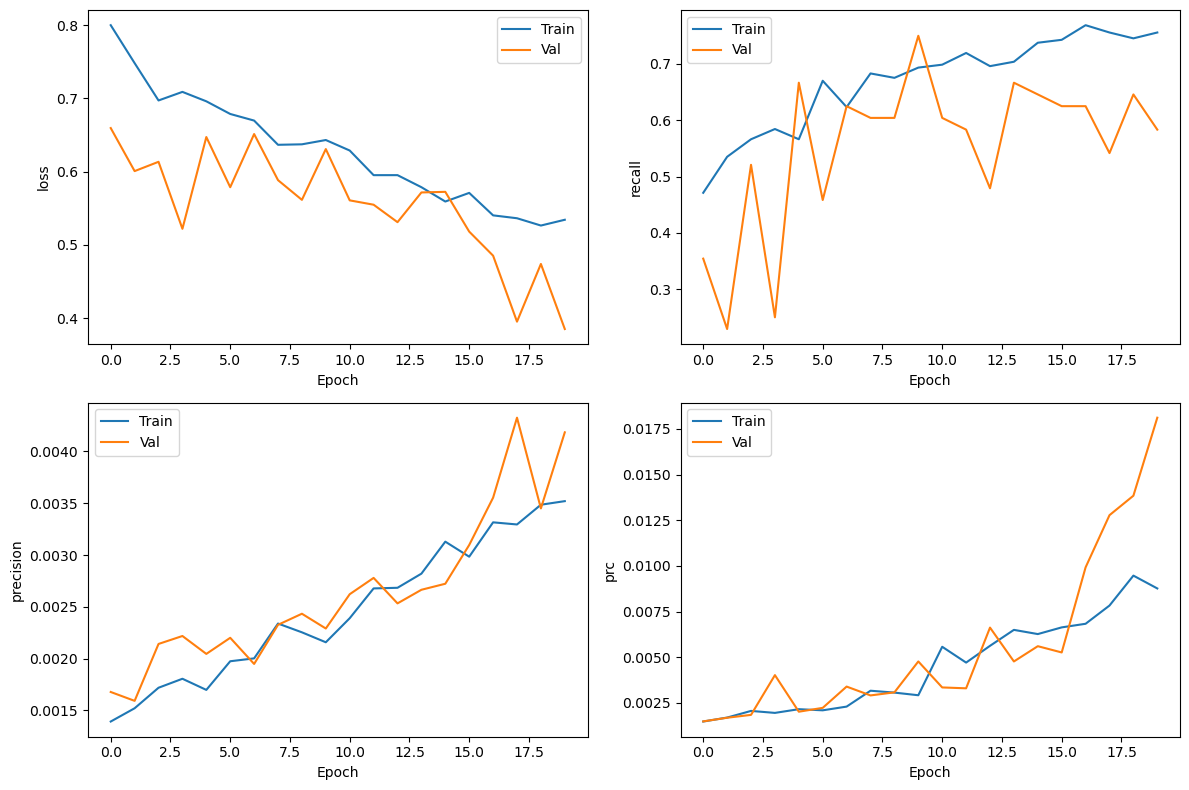

In [21]:
plot_training_metrics(history_class_weights)

In [22]:
val_predictions = model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


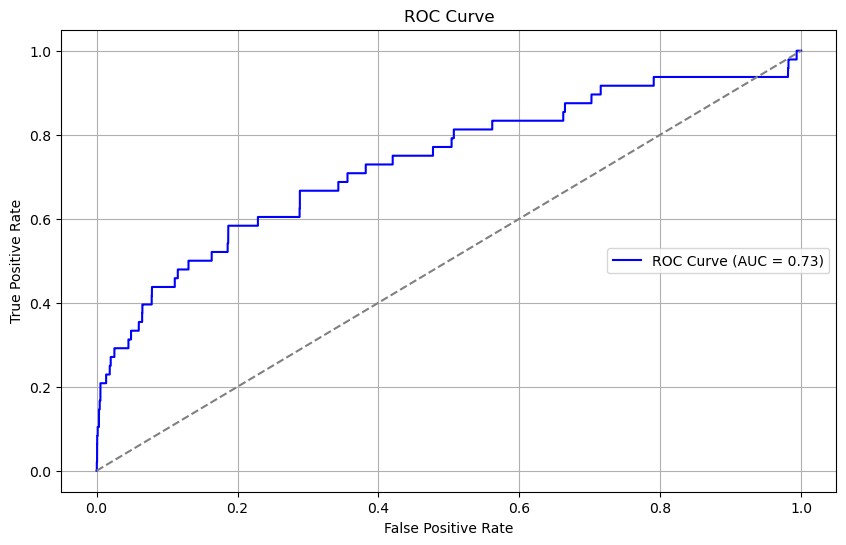

0.734179018687017

In [23]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:65: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


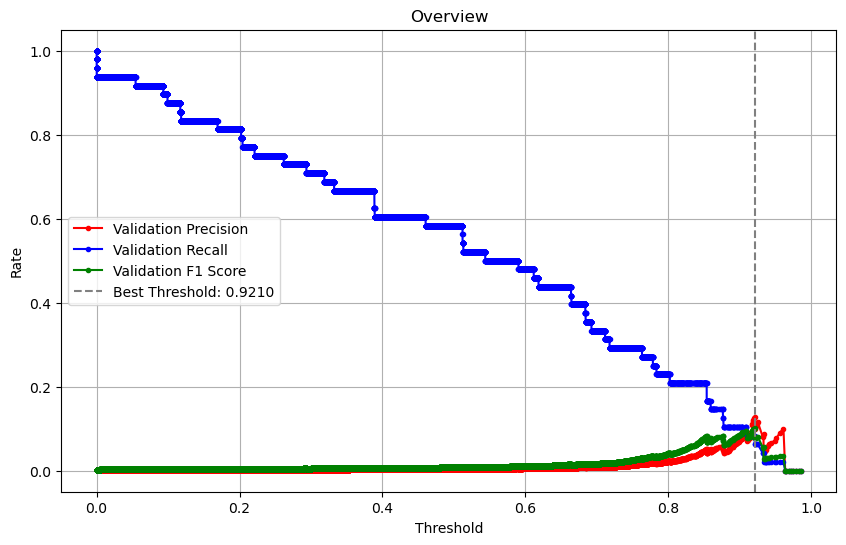

In [24]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [25]:
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 3ms/step


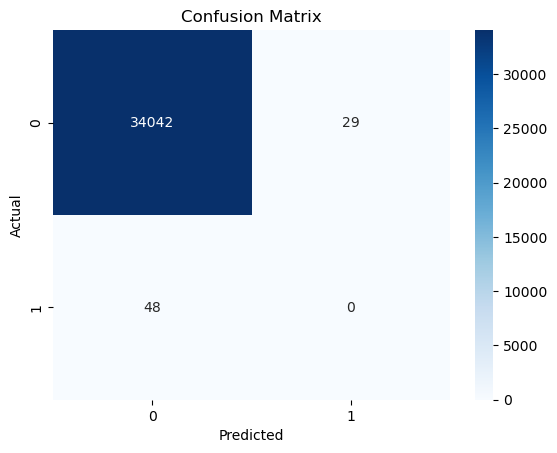

Recall       = 0.0
Precision    = 0.0
F1           = 0.0


In [26]:
_ = get_result(Y_test, test_predictions, best_threshold)

### Using oversampling 

There are different kinds of techniques for oversampling. The simplest would be Random oversampling, which just duplicates existing samples from the minority class to balance the distribution. However, this can result in overfitting as the same samples are repeated. Instead we could use Synthetic Minority Over-sampling Technique (SMOTE). The way SMOTE does it, is by generating synthetic examples in the feature space of the minority class, which helps to overcome the overfitting problem, since it is not just a copy of existing samples. The drawback of SMOTE is it can generate noisy or unrealistic samples. We will however use SMOTE to oversample on the risky customers.

In [27]:
smote = SMOTE(sampling_strategy='minority') 
X_train_oversampled, Y_train_oversampled = smote.fit_resample(X_train, Y_train)
Y_train_oversampled.value_counts()

RISK
0    272559
1    272559
Name: count, dtype: int64

In [28]:
model = get_simple_model()

history_oversampled = model.fit(
    X_train_oversampled,
    Y_train_oversampled,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
267/267 [==============================] - 6s 15ms/step - loss: 0.3290 - tp: 241290.0000 - fp: 60052.0000 - tn: 246577.0000 - fn: 31317.0000 - accuracy: 0.8423 - precision: 0.8007 - recall: 0.8851 - prc: 0.9184 - val_loss: 4.4050 - val_tp: 48.0000 - val_fp: 33689.0000 - val_tn: 381.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0126 - val_precision: 0.0014 - val_recall: 1.0000 - val_prc: 0.0049
Epoch 2/20
267/267 [==============================] - 4s 14ms/step - loss: 0.1160 - tp: 265025.0000 - fp: 15319.0000 - tn: 257240.0000 - fn: 7534.0000 - accuracy: 0.9581 - precision: 0.9454 - recall: 0.9724 - prc: 0.9864 - val_loss: 0.7778 - val_tp: 30.0000 - val_fp: 9229.0000 - val_tn: 24841.0000 - val_fn: 18.0000 - val_accuracy: 0.7290 - val_precision: 0.0032 - val_recall: 0.6250 - val_prc: 0.0123
Epoch 3/20
267/267 [==============================] - 4s 13ms/step - loss: 0.0830 - tp: 267561.0000 - fp: 10517.0000 - tn: 262042.0000 - fn: 4998.0000 - accuracy: 0.9715 - precision: 0.9622 -

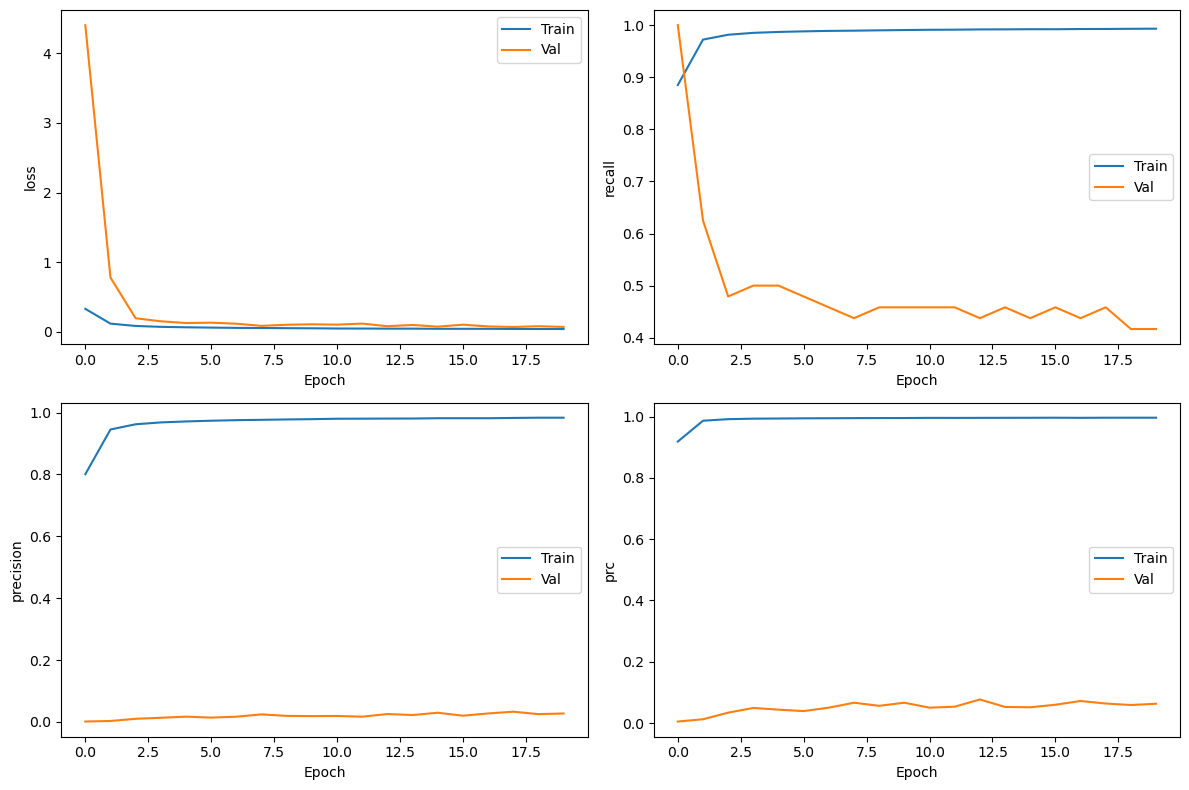

In [29]:
plot_training_metrics(history_oversampled)

In [30]:
val_predictions = model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


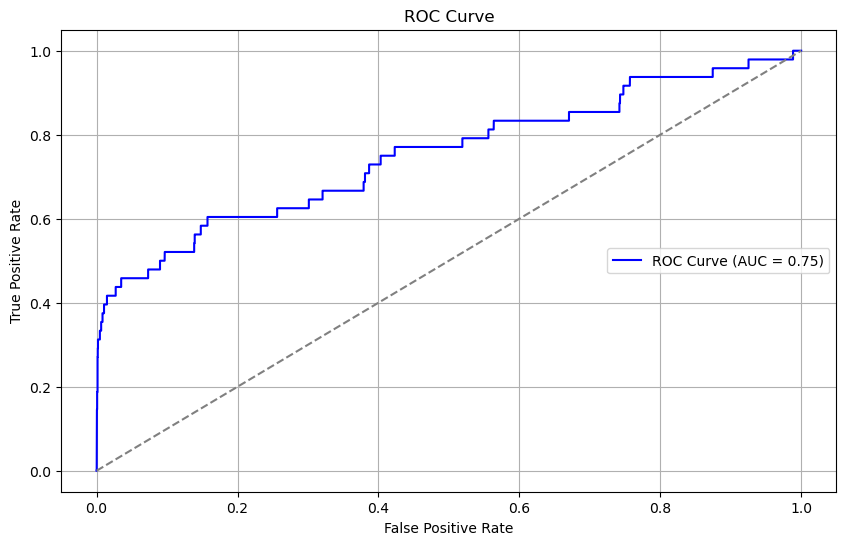

0.7521236914196263

In [31]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:65: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


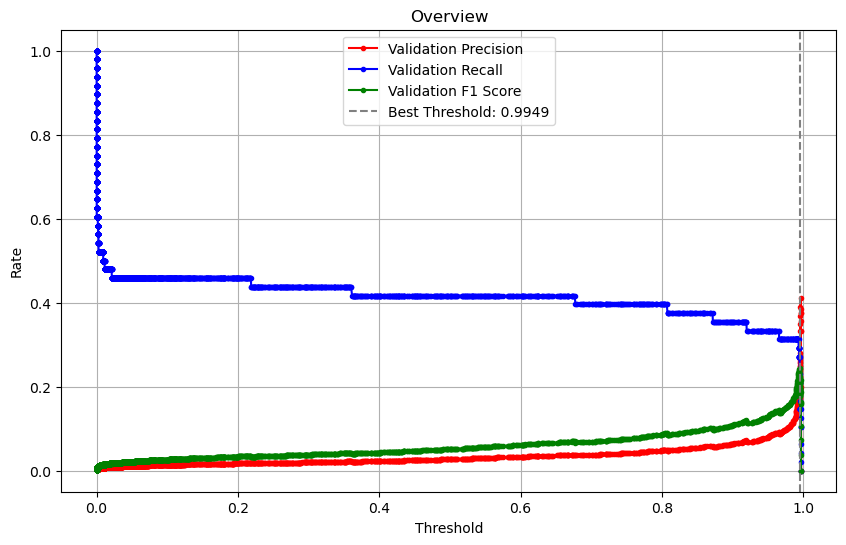

In [32]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [33]:
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 3ms/step


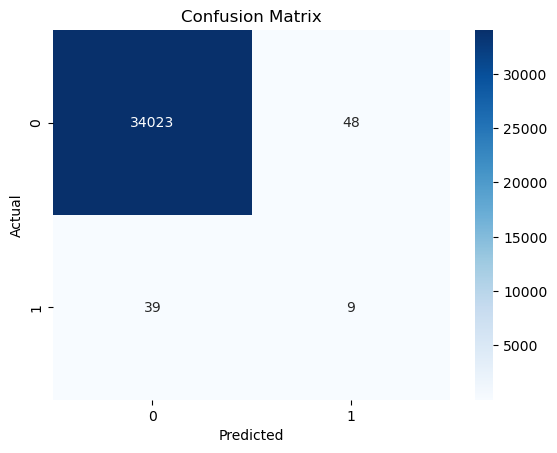

Recall       = 0.19
Precision    = 0.16
F1           = 0.17


In [34]:
_ = get_result(Y_test, test_predictions, best_threshold)

### Results of the experiment
- All the models could use some regularization (we will handle that later)
- Using nothing to handle the imbalance did okay but not good (was not the point here)
- Using class weights was the worst of the three models
    - Could be the result of too high a weight for the risky customers and too low for the normal customers, which would mean that the model focuses more on reducing errors for risky customers. However, it did not do much better on the recall anyway. Trying out different weights could improve the performance.
- Using oversampling was the the best but again not really good.

Handling imbalance is clearly an important part to create a good model. However as demonstrated, you need to test out different methods to find out what works best.

## Find the best model
Lets try to find the possible model. To do that we'll create a function that can build a model with different hyperparameters.

In [35]:
def model_builder(hp):
    """
    Build and compile a model using hyperparameters defined in Keras Tuner.

    Args:
        hp (kt.HyperParameters): Object for defining hyperparameter search space.

    Returns:
        model: A compiled Keras model.
    """

    model = Sequential()
    model.add(Dense(
        units=hp.Int("input_layer", min_value=128, max_value=1024, step=32), 
        input_shape=(X_train_oversampled.shape[1],),
        activation='relu',
        kernel_regularizer=l2(hp.Float(f"l2_0", min_value=0.0001, max_value=0.1, step=0.0005))
    ))

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(Dense(
            # Tune the number of units
            units=hp.Int(f"units_{i+1}", min_value=128, max_value=2048, step=128),
            activation='relu',
            kernel_regularizer=l2(hp.Float(f"l2_{i}", min_value=0.0001, max_value=0.1, step=0.0005))
        ))

        # Optionally add Dropout and BatchNormalization
        if hp.Boolean(f"dropout_{i}"):
            model.add(Dropout(rate=hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.7, step=0.1)))
        if hp.Boolean(f"batch_norm_{i}"):
            model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])), # Tune the leraning rate
        loss=BinaryCrossentropy(),
        metrics= METRICS
    )
    
    return model

In [36]:
monitor = 'val_prc'

In [37]:
model_builder(kt.HyperParameters())

tuner = kt.BayesianOptimization(
    hypermodel=model_builder,
    objective=kt.Objective(monitor, direction="max"),   # Objective to optimize
    max_trials=30,                                      # Number of trials to run during the search
    executions_per_trial=2,                             # Models that should be built and fit for each trial
    overwrite=True,                                     # Overwrite the previous results
    directory="Saved models",
    project_name="NN_Model_tuner",
)

tuner.search_space_summary()

Search space summary
Default search space size: 7
input_layer (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
l2_0 (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': 0.0005, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 2048, 'step': 128, 'sampling': 'linear'}
dropout_0 (Boolean)
{'default': False, 'conditions': []}
batch_norm_0 (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


We are going to utilize a callback when running the RandomSearch:
- EarlyStopping: To stop training when the model stop to improve on the monitored metric for a number of epochs. Here we also restore the weights, which resulted in the best performence on the monitored metric.

In [38]:
# Early stopping callback for efficient training
early_stopping = EarlyStopping(
    monitor=monitor,
    patience=7,
    mode='max',
    restore_best_weights=True
)

In [39]:
tuner.search(
    X_train_oversampled,
    Y_train_oversampled,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Trial 30 Complete [00h 01m 44s]
val_prc: 0.06240491010248661

Best val_prc So Far: 0.1526990607380867
Total elapsed time: 00h 53m 21s


In [40]:
# See the result of all the models
tuner.results_summary()

Results summary
Results in Saved models/NN_Model_tuner
Showing 10 best trials
Objective(name="val_prc", direction="max")

Trial 17 summary
Hyperparameters:
input_layer: 544
l2_0: 0.0391
num_layers: 4
units_1: 896
dropout_0: False
batch_norm_0: False
learning_rate: 0.0001
dropout_rate_0: 0.30000000000000004
units_2: 512
l2_1: 0.0036
dropout_1: True
batch_norm_1: True
dropout_rate_1: 0.2
units_3: 896
l2_2: 0.0366
dropout_2: True
batch_norm_2: False
dropout_rate_2: 0.4
units_4: 384
l2_3: 0.022099999999999998
dropout_3: False
batch_norm_3: False
dropout_rate_3: 0.5
units_5: 1664
l2_4: 0.0776
dropout_4: False
batch_norm_4: False
dropout_rate_4: 0.30000000000000004
Score: 0.1526990607380867

Trial 06 summary
Hyperparameters:
input_layer: 384
l2_0: 0.0016
num_layers: 2
units_1: 768
dropout_0: False
batch_norm_0: False
learning_rate: 0.0001
dropout_rate_0: 0.5
units_2: 896
l2_1: 0.055600000000000004
dropout_1: True
batch_norm_1: False
dropout_rate_1: 0.30000000000000004
units_3: 2048
l2_2: 0.0

In [41]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
for value in best_hps.values:
    print(value, ':', best_hps.values[value])  # Inspect the hyperparameter values

input_layer : 544
l2_0 : 0.0391
num_layers : 4
units_1 : 896
dropout_0 : False
batch_norm_0 : False
learning_rate : 0.0001
dropout_rate_0 : 0.30000000000000004
units_2 : 512
l2_1 : 0.0036
dropout_1 : True
batch_norm_1 : True
dropout_rate_1 : 0.2
units_3 : 896
l2_2 : 0.0366
dropout_2 : True
batch_norm_2 : False
dropout_rate_2 : 0.4
units_4 : 384
l2_3 : 0.022099999999999998
dropout_3 : False
batch_norm_3 : False
dropout_rate_3 : 0.5
units_5 : 1664
l2_4 : 0.0776
dropout_4 : False
batch_norm_4 : False
dropout_rate_4 : 0.30000000000000004


In [42]:
# Build the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 544)               29376     
                                                                 
 dense_6 (Dense)             (None, 896)               488320    
                                                                 
 dense_7 (Dense)             (None, 512)               459264    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 896)               459648    
                                                      

Before training the best model again we are going to utilize some additional callbacks:
- ModelCheckpoint: To save the best weights depending on a monitored metric.
- TensorBoard: 

In [43]:
# Model checkpoint callback for securing best weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=r'Saved models/NN_best_model.keras',
    save_weights_only=False, # Save the entire model (architecture + weights)
    monitor=monitor,
    mode='max',
    save_best_only=True
)

In [44]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # directory to store logs
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [45]:
# Train the best model and capture the training history
history_best = best_model.fit(
    X_train_oversampled,
    Y_train_oversampled,
    validation_data=(X_val, Y_val),
    epochs=50, 
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback]
)

Epoch 1/50
267/267 [==============================] - 5s 14ms/step - loss: 40.0742 - tp: 233923.0000 - fp: 50537.0000 - tn: 256092.0000 - fn: 38684.0000 - accuracy: 0.8460 - precision: 0.8223 - recall: 0.8581 - prc: 0.9219 - val_loss: 20.3862 - val_tp: 33.0000 - val_fp: 7763.0000 - val_tn: 26307.0000 - val_fn: 15.0000 - val_accuracy: 0.7720 - val_precision: 0.0042 - val_recall: 0.6875 - val_prc: 0.0318
Epoch 2/50
267/267 [==============================] - 3s 12ms/step - loss: 11.1795 - tp: 269420.0000 - fp: 9907.0000 - tn: 262652.0000 - fn: 3139.0000 - accuracy: 0.9761 - precision: 0.9645 - recall: 0.9885 - prc: 0.9963 - val_loss: 5.4877 - val_tp: 25.0000 - val_fp: 1588.0000 - val_tn: 32482.0000 - val_fn: 23.0000 - val_accuracy: 0.9528 - val_precision: 0.0155 - val_recall: 0.5208 - val_prc: 0.0762
Epoch 3/50
267/267 [==============================] - 3s 12ms/step - loss: 3.0189 - tp: 271134.0000 - fp: 6363.0000 - tn: 266196.0000 - fn: 1425.0000 - accuracy: 0.9857 - precision: 0.9771 - 

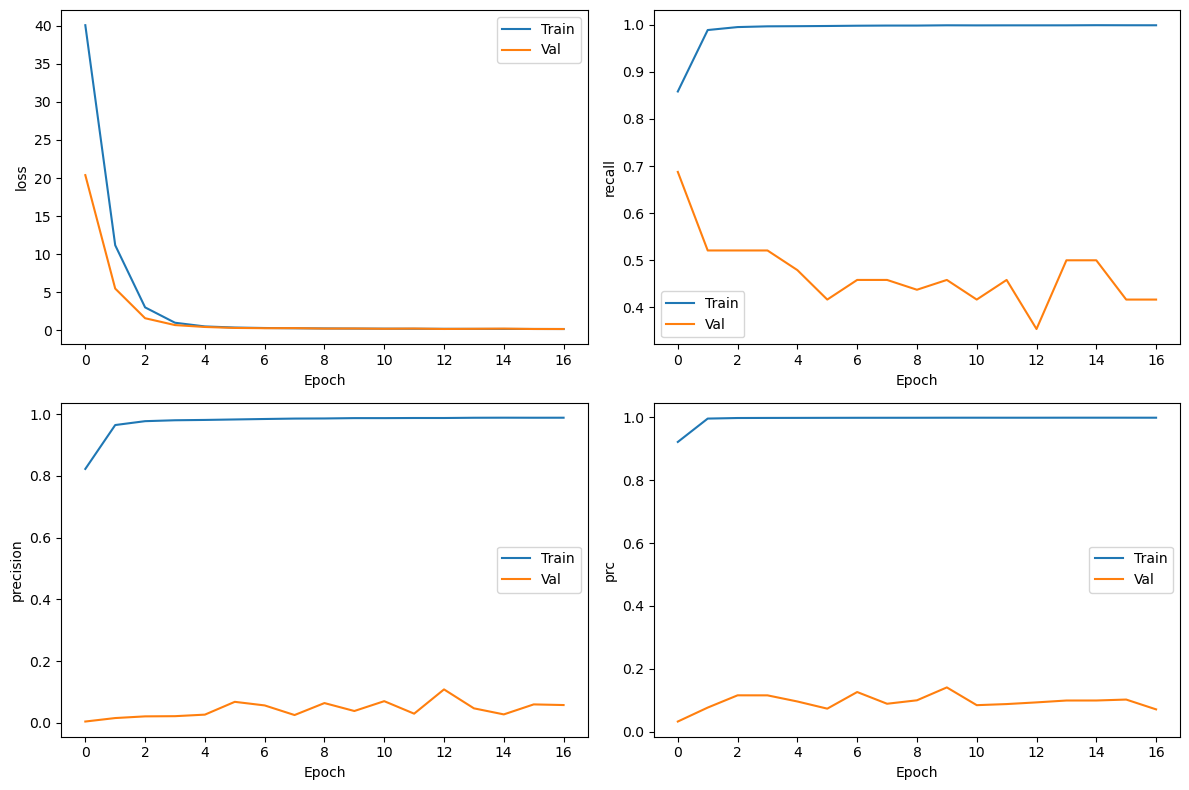

In [46]:
plot_training_metrics(history_best)

In [47]:
# Test model on val set
val_predictions = best_model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


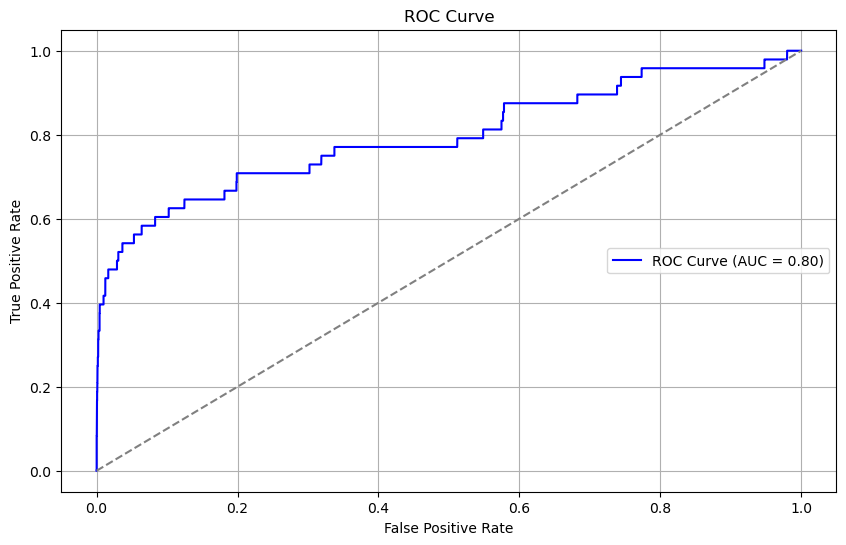

0.7959489042168085

In [48]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:65: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


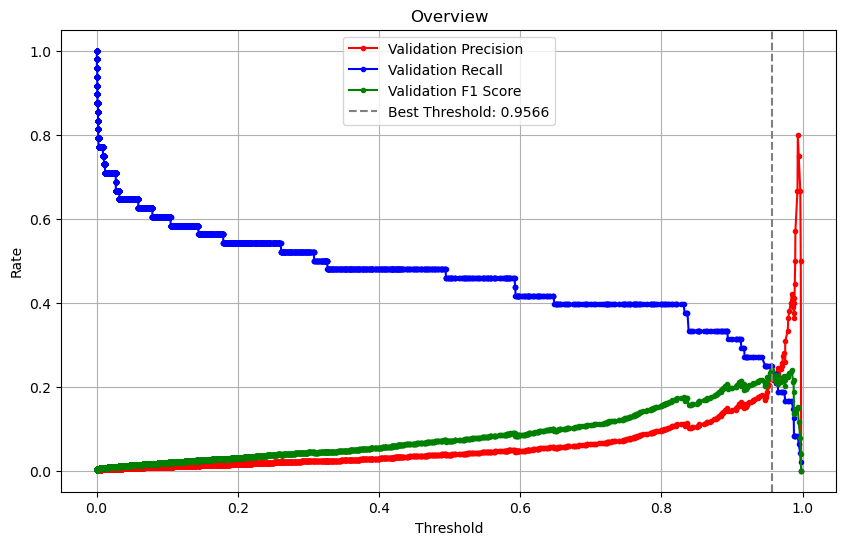

In [49]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [50]:
# Test model on test set
test_predictions = best_model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


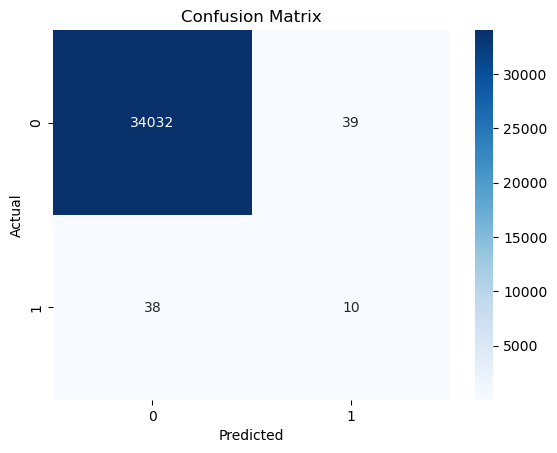

Recall       = 0.21
Precision    = 0.2
F1           = 0.21


In [55]:
result = get_result(Y_test, test_predictions, best_threshold)

This is definitely not a great result. We could only find 10 out of 48 risky customers...

It could be interesting to see, how close our best threshold is to the actual best threshold for the test set, when we want to maximize the F1 score. Let's see.

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:65: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


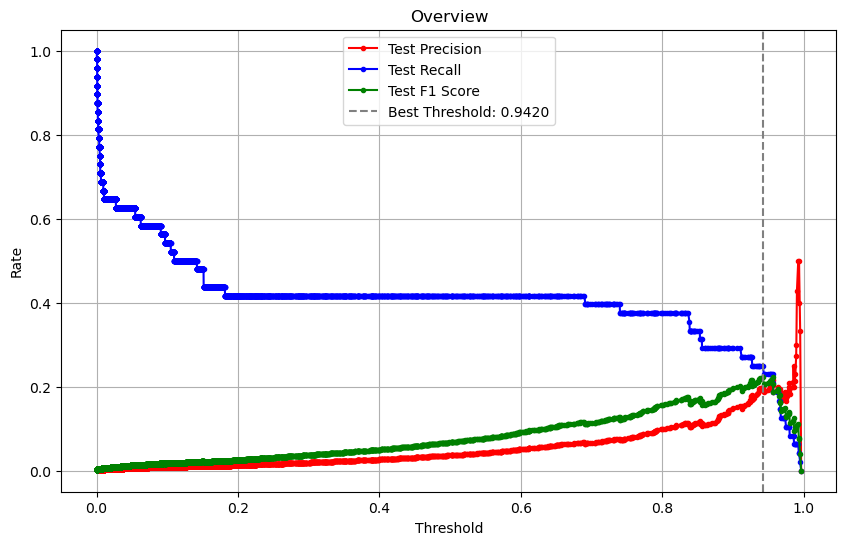

Difference between thresholds: 0.0145820975


In [61]:
best_threshold_test = get_best_threshold('Test', Y_test, test_predictions)
print('Difference between thresholds:', best_threshold - best_threshold_test)

I'll say we hit the optimal threshold pretty good.

Let's save the model we found

In [53]:
save_metrics_to_json('Neural Network', float(result['recall']), float(result['precision']), float(result['f1']), float(best_threshold))